In [1]:
import datetime
import numpy as np
import pandas as pd
import mplfinance as mpf
import time
import matplotlib.pyplot as plt
import ccxt 
import pprint

In [2]:

with open("a.txt") as f:
    lines = f.readlines()
    api_key = lines[0].strip()
    secret  = lines[1].strip()

binance = ccxt.binance(config={
    'apiKey': api_key, 
    'secret': secret,
    'enableRateLimit': True,
    'options': {
        'defaultType': 'future'
    }
})
binance.load_markets()
sym = 'ETH/USDT'
def past_data(sym, tf, limit, since=None):
    coininfo = binance.fetch_ohlcv(
        symbol=sym, 
        timeframe=tf, 
#         since=since, 
        limit=limit
    )
    df = pd.DataFrame(coininfo, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    df.set_index('datetime', inplace=True)
    return df


In [3]:
balance = binance.fetch_balance()
positions = balance['info']['positions']

for position in positions:
#     print(position)
    if position["symbol"] == sym.replace("/", ""):
        print(position['positionAmt'])

0.017


In [5]:

def show_default_graph(m1, m2=None, m3=None, m4=None, n=100, title=''):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize = (12,6))

    n = len(m1)
#     mpf.plot(df,type='candle', volume=False, style='charles', ax=ax)
    xpoints = np.arange(len(m1))[-n:]

    if str(type(m1)) != "<class 'NoneType'>":
        ax.plot(xpoints, m1[-n:], color = (1, 0.7, 0), linewidth = 2, label='Close, 5-Day SMA')
    if str(type(m2)) != "<class 'NoneType'>":
        ax.plot(xpoints, m2[-n:], color = (1, 0.3, 0.3), linewidth = 1, label='Close, 20-Day SMA')
    if str(type(m3)) != "<class 'NoneType'>":
        ax.plot(xpoints, m3[-n:], color = (0.3, 0.3, 1), linewidth = 1, label='Close, 40-Day SMA')
    if str(type(m4)) != "<class 'NoneType'>":
        ax.plot(xpoints, m4[-n:], color = (0.6, 0.7, 1), linewidth = 1, label='Close, 40-Day SMA')

    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')

    ax.set_title(title)
    return ax

def show_transaction(transactions, m1=None, m2=None, m3=None, m4=None, n=100, title=''):
    n = len(m1)
    if n < 200:
        R = 2
    elif n < 500:
        R = 5
    else:
        R = 10
    ax = show_default_graph(m1, m2, m3, m4)
    for tr in transactions:
        color = 'b' if tr['position'] == 'Short' else 'r'
        ax.add_patch(plt.Arrow(
            tr['ent'][0], tr['ent'][1], 
            tr['close'][0]-tr['ent'][0], tr['close'][1]-tr['ent'][1],
            width = R, color=color, zorder=2
        ))
    return ax


def show_total_pnl(transactions):
    pnls=[]
    for tr in transactions:
        pnls.append(float(tr['pnl'][:-1]))
    total_pnl = np.sum(pnls)
#     print(f"{total_pnl} %")
    return total_pnl

def min_to_dhm(minute):
    running_d = minute//(60*24)
    running_h = (minute - (60*24)*running_d)//60
    running_m = minute - (60*24)*running_d - (60)*running_h
    return f"{running_d}D {running_h}H {running_m}m"

""" -----Rule-----
1. m2 ^ & m3 v & m4 /: 롱 진입
   m4 하락하기 시작: 롱 정리
2. m2 v & m3 ^ & m4 \: 숏 진입 
   m4 상승하기 시작: 숏 정리
3. 0.05% 이상 수익이 아니면 안팔기
4. 0.1% 이상 손실이면 팔기
"""

def timing2_close(status, m2, m3, m4, i):
    if i < 2:
        return False
    m4_inc1 = m4[i-1] - m4[i-2] 
    m4_inc2 = m4[i] - m4[i-1] 
    if status == "Long": # n
        m4_turn = m4_inc1>0 and m4_inc2 <0
    else:
        m4_turn = m4_inc1<0 and m4_inc2 >0
    return m4_turn

def close(pos, tr, lev=1):
    p=1
    if pos == "Short":
        p = -1
    tr['position'] = pos
    profit = p*(tr['close'][1] - tr['ent'][1])/tr['ent'][1] # 1 means price
    profit = 100*profit - 0.08
    tr['pnl'] = str(round(lev*profit, 4))+"%"
    return tr

def simul(m1, m2, m3, m4, just_one_tr=False):
    status = None
    transactions = []
    tr = {}
    curr_pnl = 0
    ent_i = 0
    for i in range(2, len(m1)):
        if not status:
#             m2on3 = m2[i] - m3[i] > 0    
#             p_m2on3 = m2[i-1] - m3[i-1] > 0
#             pp_m2on3 = m2[i-2] - m3[i-2] > 0
            
#             m4_increasing = m4[i] - m4[i-1] > 0
#             if not m4[i-1] >0:
#                 continue
#             m23_start_inc = not p_m2on3 and m2on3 
#             m23_start_dec = p_m2on3 and not m2on3
            
#             if m23_start_inc and not m4_increasing:
#                 status = "Long"
#             elif m23_start_dec and m4_increasing:
#                 status = "Short"
            
            

            if status:
                print(f">>{i} {status} entry price: {m1[i]}")
                tr['ent'] = [i, m1[i]]
                ent_price = m1[i]
                ent_i = i
        else :
            p = 2*(-0.5+int(status=="Long"))
            curr_pnl = p*(m1[i] - ent_price)/ent_price*100
            if curr_pnl < -0.3 or\
            (
                curr_pnl > 0.1 and\
                timing2_close(status, m2, m3, m4, i)
            )or\
            (
                i-ent_i > 100 and curr_pnl > 0.1
            ):
#                 print(curr_pnl, status)
                tr['close'] = [i, m1[i]]
                tr = close(status, tr)
                transactions.append(tr)
                tr = {}
                status = None
                if just_one_tr:
                    return i, transactions
    print(curr_pnl, "%")
    return 0, transactions

In [6]:
def get_best_ws(df, max2=20, max3=30, max4=50):
    best_pnl = 0
    best_tr = None
    ws = []
    for w2 in range(2,max2):
        for w3 in range(w2+1, max3):
            for w4 in range(w3+1, max4):
                transactions, total_pnl = simulate(df, w2, w3, w4)
                if total_pnl > best_pnl:
                    best_pnl = total_pnl
                    best_tr = (transactions, m1, m2, m3, m4)
                    ws.append([w2, w3, w4])
                    print(f"w2={w2}, w3={w3}, w4={w4} pnl:{total_pnl} %")
    return ws

def simulate(df, w2, w3, w4, show_graph=False, just_one_tr=False):
    m1 = df['close'].rolling(window=1).mean()
    m2 = df['close'].rolling(window=w2).mean()
    m3 = df['close'].rolling(window=w3).mean()
    m4 = df['close'].rolling(window=w4).mean()
    i, transactions = simul(m1, m2, m3, m4, just_one_tr=just_one_tr)
    if show_graph:
        show_transaction(transactions, m1, m2, m3, m4)
    total_pnl = show_total_pnl(transactions)
    if just_one_tr:
        return i, transactions, total_pnl
    return transactions, total_pnl
    

test unit: 0D 12H 30m
total:  1D 1H 0m
--------------------[0 ~ 750]
0 %
[0 [11, 20, 40]] PNL:0.0%
--------------------[750 ~ 1500]
0 %
[750 [11, 20, 40]] PNL:0.0%
0.0 %


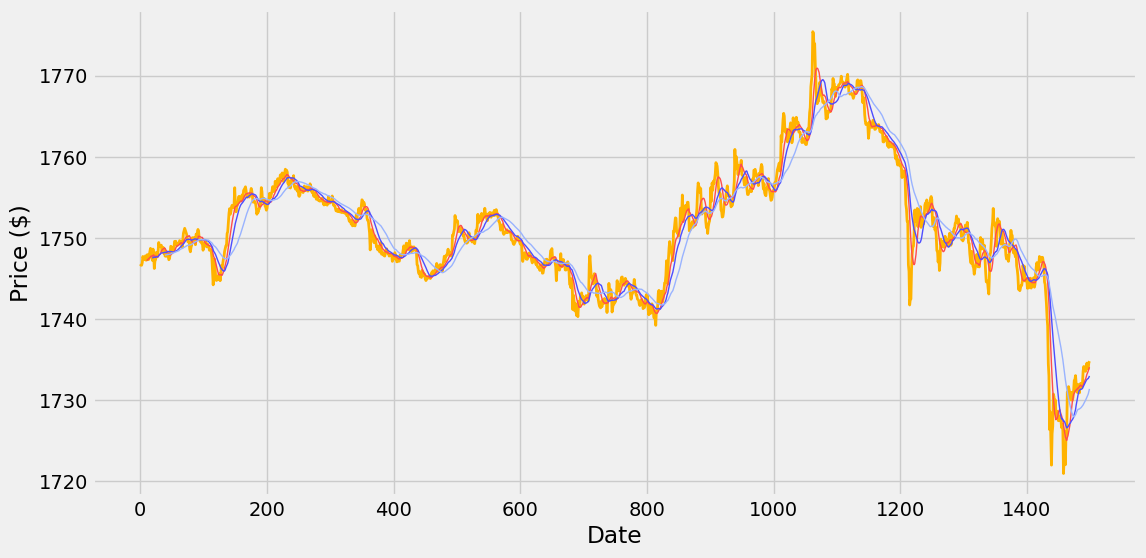

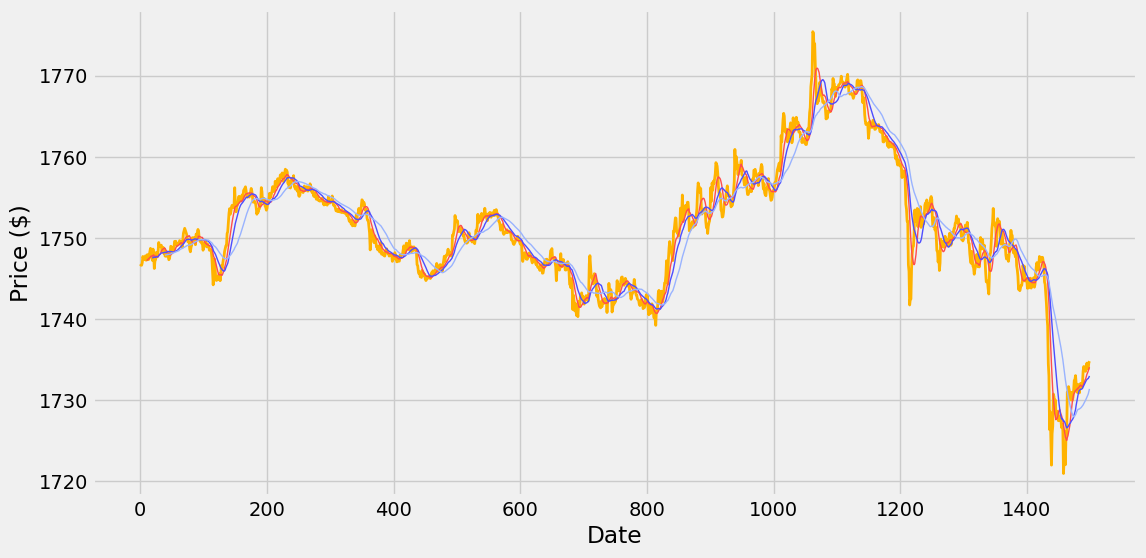

In [7]:

tf = '1m'
minute = int(tf[:-1])
raw_df = past_data(sym, tf, limit=10000)
df = raw_df
# 1500 tf 몇등분 할거야
testnum = 2
# 1500/testnum 의 시간은 얼마야
total_m = len(df)*minute  # 1500
test_m = int(total_m/testnum)  # 500
print(f'test unit: '+min_to_dhm(test_m))
print('total: ', min_to_dhm(total_m))

# 첫번째 블럭 예측 ws
unit = int(len(df)/testnum)
PNL = []
ws = [[11, 20, 40]]
for idx in range(0, len(df), unit):
    idx2 = idx+unit
    print(f"{'-'*20}[{idx} ~ {idx2}]")
    test_df = df[idx:idx2]
    if idx == -1:  ## 예측값 생성
#         ws = get_best_ws(test_df)[-1]
#         ws = [[11, 11, 17]]
#         ws = [[2*minute, 11*minute, 17*minute]]
        pass
    else:
        wws = ws[-1]
        i = 0
        trs = []
        while i < len(test_df):
            i2, transactions, total_pnl = simulate(test_df[i:], *wws, just_one_tr=True)
            print(f"[{idx+i} {wws}] PNL:{round(total_pnl, 3)}%")
            PNL.append(total_pnl)
            for tr in transactions:
                tr['ent'][0] += idx+i
                tr['close'][0] += idx+i
                
            trs += transactions
#             wws = get_best_ws(df[:idx+i])[-1]
#             print(f"df[~{idx+i}] {wws}")
            if i2 == 0:
                break
            i += i2
        w2, w3, w4 = wws 
        m1 = df['close'].rolling(window=1).mean()
        m2 = df['close'].rolling(window=w2).mean()
        m3 = df['close'].rolling(window=w3).mean()
        m4 = df['close'].rolling(window=w4).mean()
        show_transaction(trs, m1, m2, m3, m4)

print(np.sum(PNL), '%')

In [72]:
################################################################################

test unit: 7D 19H 30m
total:  15D 15H 0m
--------------------[0 ~ 750]
>>19 Long entry price: 1817.5
[0 [2, 11, 17]] PNL:-0.386%
>>18 Short entry price: 1813.01
[66 [2, 11, 17]] PNL:0.12%
>>27 Long entry price: 1801.79
[103 [2, 11, 17]] PNL:0.628%
>>19 Short entry price: 1813.63
[169 [2, 11, 17]] PNL:-0.536%
>>26 Short entry price: 1815.45
[193 [2, 11, 17]] PNL:-0.972%
>>21 Short entry price: 1855.81
[221 [2, 11, 17]] PNL:0.289%
>>26 Short entry price: 1852.56
[287 [2, 11, 17]] PNL:1.875%
>>22 Long entry price: 1794.14
[360 [2, 11, 17]] PNL:-0.464%
>>37 Long entry price: 1779.92
[385 [2, 11, 17]] PNL:0.813%
>>19 Short entry price: 1806.49
[473 [2, 11, 17]] PNL:-0.588%
>>17 Long entry price: 1813.46
[535 [2, 11, 17]] PNL:0.941%
>>24 Long entry price: 1827.1
[581 [2, 11, 17]] PNL:0.15%
>>19 Long entry price: 1825.82
[628 [2, 11, 17]] PNL:0.028%
>>20 Long entry price: 1823.57
[650 [2, 11, 17]] PNL:1.227%
>>22 Long entry price: 1845.02
-0.19837183336766442 %
[717 [2, 11, 17]] PNL:0.0%
----

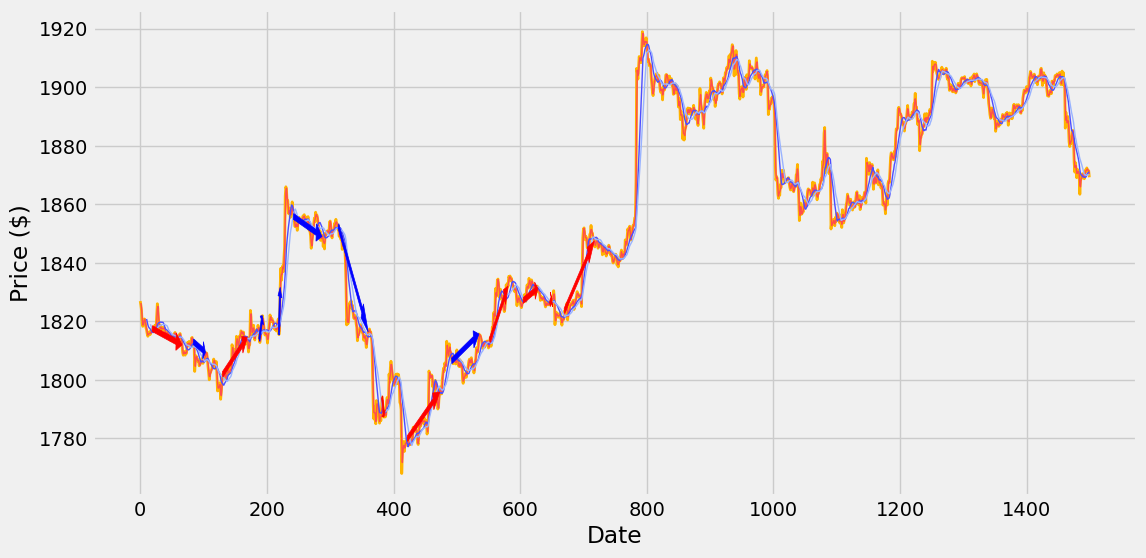

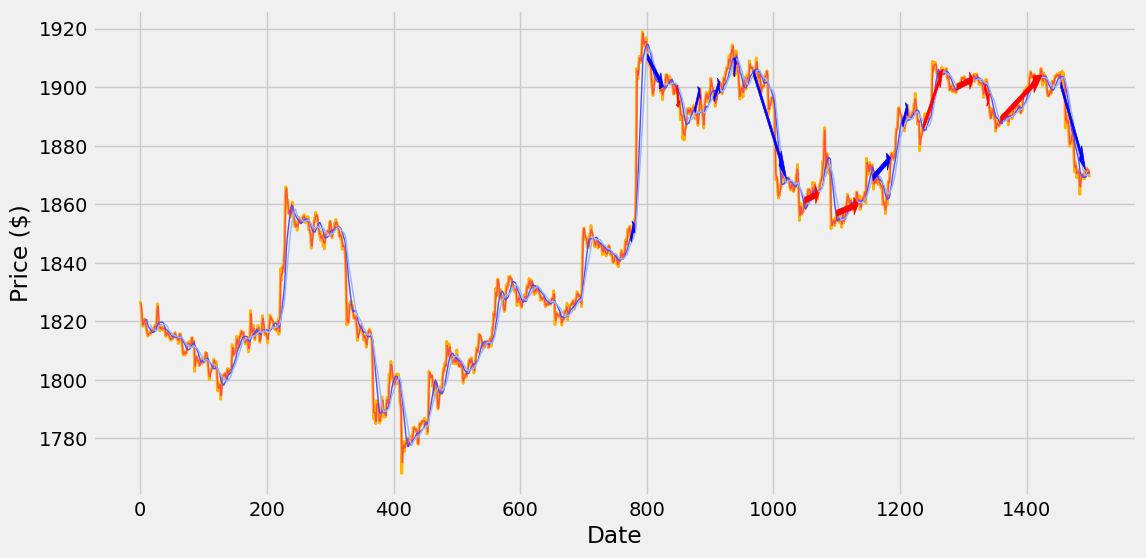

In [73]:

tf = '15m'
minute = int(tf[:-1])
raw_df = past_data(sym, tf, limit=10000)
df = raw_df
# 1500 tf 몇등분 할거야
testnum = 2
# 1500/testnum 의 시간은 얼마야
total_m = len(df)*minute  # 1500
test_m = int(total_m/testnum)  # 500
print(f'test unit: '+min_to_dhm(test_m))
print('total: ', min_to_dhm(total_m))

# 첫번째 블럭 예측 ws
unit = int(len(df)/testnum)
PNL = []
ws = [[2, 11, 17]]
for idx in range(0, len(df), unit):
    idx2 = idx+unit
    print(f"{'-'*20}[{idx} ~ {idx2}]")
    test_df = df[idx:idx2]
    if idx == -1:  ## 예측값 생성
#         ws = get_best_ws(test_df)[-1]
        ws = [[2, 11, 17]]
#         ws = [[2*minute, 11*minute, 17*minute]]
    else:
        wws = ws[-1]
        i = 0
        trs = []
        while i < len(test_df):
            i2, transactions, total_pnl = simulate(test_df[i:], *wws, just_one_tr=True)
            print(f"[{idx+i} {wws}] PNL:{round(total_pnl, 3)}%")
            PNL.append(total_pnl)
            for tr in transactions:
                tr['ent'][0] += idx+i
                tr['close'][0] += idx+i
                
            trs += transactions
#             wws = get_best_ws(df[:idx+i])[-1]
#             print(f"df[~{idx+i}] {wws}")
            if i2 == 0:
                break
            i += i2
        w2, w3, w4 = wws 
        m1 = df['close'].rolling(window=1).mean()
        m2 = df['close'].rolling(window=w2).mean()
        m3 = df['close'].rolling(window=w3).mean()
        m4 = df['close'].rolling(window=w4).mean()
        show_transaction(trs, m1, m2, m3, m4)

print(np.sum(PNL), '%')